# LF

In [1]:
import numpy as np
import gpjax as gpx
import os
import jax
import matplotlib.pyplot as plt
import jax.random as jr

from dataclasses import dataclass, field

from beartype.typing import Union
import jax.numpy as jnp
from jaxtyping import Float
import tensorflow_probability.substrates.jax.bijectors as tfb
import tensorflow_probability.substrates.jax.distributions as tfd

from gpjax.base import param_field, static_field
from gpjax.kernels.base import AbstractKernel
from gpjax.kernels.stationary.utils import squared_distance
from gpjax.typing import (
    Array,
    ScalarFloat,
)

from beartype.typing import Callable
from jaxtyping import Int

from p53_data import JAXP53_Data, dataset_3d, flatten_dataset_jax
jax.config.update('jax_enable_x64', True)

from matplotlib import rcParams

plt.style.use("https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle")

# Check if LaTeX is in notebook path
if os.environ.get('PATH') is not None:
    if 'TeX' not in os.environ['PATH']:
        os.environ['PATH'] += os.pathsep + '/Library/TeX/texbin'

colors = rcParams["axes.prop_cycle"].by_key()["color"]

import tensorflow_probability.substrates.jax.bijectors as tfb

key = jr.PRNGKey(42)

/opt/anaconda3/envs/project_wp289/lib/python3.11/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


In [2]:
p53_data = JAXP53_Data(replicate=2)
training_times, gene_expressions = dataset_3d(p53_data)

In [3]:
# Generate test points (t, i, 1):
def gen_test_times(t=100):
    """
    Generate testing times for the model of shape (N, 3) where N is the number of testing times. Default is N = 100
    """
    times = jnp.linspace(0, 12, t)
    # Gene indices shouldn't matter
    gene_indices = jnp.repeat(-1, t)
    testing_times = jnp.stack((times, gene_indices, jnp.repeat(0,t)), axis=-1)
    return testing_times

In [63]:
t18 = gen_test_times(18)

t18.shape

(18, 3)

In [4]:
@dataclass
class p53_kxx(gpx.kernels.AbstractKernel):
    r"Covariance function for expressions of genes j and k at times t and t'"

    name: str = 'k_xx'

    # BUG: crashes when using unconstrained parameters

    # Sensitivities of the genes
    initial_constrained_s = jnp.array([1.0,1.0,1.0,1.0,1.0], dtype=jnp.float64)
    initial_unconstrained_s = tfb.Softplus().inverse(initial_constrained_s)
    
    true_s: Float[Array, "1 5"] = param_field(initial_constrained_s, bijector= tfb.Softplus(), metadata={"name": " kxx_sensitivities"}, trainable=True)
    
    # Degradation rates of the genes
    initial_constrained_d = jnp.array([0.4,0.4,0.4,0.4,0.4], dtype=jnp.float64)
    initial_unconstrained_d = tfb.Softplus().inverse(initial_constrained_d)

    true_d: Float[Array, "1 5"] = param_field(initial_constrained_d, bijector= tfb.Softplus(), metadata={"name": " kxx_degradations"}, trainable=True)

    #true_d: Float[Array, "1 5"] = static_field(jnp.array([0.4,0.4,0.4,0.4,0.4]))
    

    # Sigmoid to map real numbers to (0,1) and then scales and shifts to get(0.5, 3.5) # NOTE: tfb.Chain acts Right to Left
    l_bijector = tfb.Chain([tfb.Shift(jnp.array(0.5, dtype=jnp.float64)), tfb.Scale(jnp.array(3.0, dtype=jnp.float64)), tfb.Sigmoid()])
    
    initial_constrained_l = jnp.array(2.5, dtype=jnp.float64)
    initial_unconstrained_l = l_bijector.inverse(initial_constrained_l)
    
    l: Float[Array, " O"] = param_field(initial_constrained_l, bijector=l_bijector, metadata={"name": " kxx_lengthscale"})

    
    def __call__(self, t: Int[Array, "1 3"], t_prime: Int[Array, "1 3"]) -> ScalarFloat:
        """
        Equation 5 in paper k_xx(t,t')
        """
        
        # Error trap (JAX friendly)
        def check_validity(condition):
            if condition:
                #raise ValueError("t or t' cannot be testing points (z=0)")
                return 0

        condition = jnp.logical_or(t[2] == 0, t_prime[2] == 0)
        jax.debug.callback(check_validity, condition)
        
        # Get gene indices
        j = t[1].astype(int)
        k = t_prime[1].astype(int)

        t = self.slice_input(t)
        t_prime = self.slice_input(t_prime)

        # Equation 5
        mult = self.true_s[j] * self.true_s[k] * self.l * jnp.sqrt(jnp.pi) * 0.5
        second_term = self.h(k,j, t_prime, t) + self.h(j,k, t, t_prime)
        
        kxx = mult * second_term

        return kxx.squeeze()
        
    
    def h(self,j: Int[Array, " O"],k: Int[Array, " O"],t1: Int[Array, " O"],t2: Int[Array, " O"]) -> ScalarFloat:
        """
        Analytical solution for the convolution of the exponential kernel with a step function.
        """

        t_dist = t2-t1

        multiplier = jnp.exp(self.gamma(k)**2) / (self.true_d[j] + self.true_d[k])

        first_multiplier = jnp.exp(-self.true_d[k]*t_dist)
        first_erf_terms = jax.scipy.special.erf((t_dist / self.l) - self.gamma(k)) + jax.scipy.special.erf(t1/self.l + self.gamma(k))

        second_multiplier = jnp.exp(-(self.true_d[k]*t2 + self.true_d[j]*t1))
        second_erf_terms = jax.scipy.special.erf((t2 / self.l) - self.gamma(k)) + jax.scipy.special.erf(self.gamma(k))

        result = multiplier * (jnp.multiply(first_multiplier, first_erf_terms) - jnp.multiply(second_multiplier, second_erf_terms))

        return result
    
    def gamma(self, k: Int[Array, " O"]) -> ScalarFloat:
        # Gamma term for h function
        return (self.true_d[k] * self.l) /2

In [5]:
@dataclass
class p53_kxf(gpx.kernels.AbstractKernel):
    r"Cross-covariance between gene expression j at time t and f at time t'"

    name: str = 'k_xf'

    true_s: Float[Array, "1 5"] = param_field(jnp.array([1.0,1.0,1.0,1.0,1.0]), bijector= tfb.Softplus(), metadata={"name": " kxf_sensitivities"}, trainable=False)
    true_d: Float[Array, "1 5"] = param_field(jnp.array([1.0,1.0,1.0,1.0,1.0]), bijector= tfb.Softplus(), metadata={"name": " kxf_degradations"}, trainable=False)

    l: Float[Array, " O"] = param_field(jnp.array(2.5), bijector=tfb.Softplus(), metadata={"name": " kxf_lengthscale"}, trainable=False)

    def __call__(self, t: Int[Array, "1 3"], t_prime: Int[Array, "1 3"]) -> ScalarFloat:
        # Get gene expression and latent force from flag (kxf anf kfx are transposes)
        gene_xpr = jnp.where(t[2] == 0, t_prime, t)
        latent_force = jnp.where(t[2] == 0, t, t_prime)
    
        j = gene_xpr[1].astype(int)

        #print(f'Latent force {latent_force}')
        #print(f'Gene expression {gene_xpr}') 

        # Slice inputs
        gene_xpr = self.slice_input(gene_xpr)
        latent_force = self.slice_input(latent_force)

        #print(f'Latent force {latent_force}')
        #print(f'Gene expression {gene_xpr}')

        t_dist = jnp.abs(gene_xpr - latent_force)   
        
        first_term = 0.5 * self.l * jnp.sqrt(jnp.pi) * self.true_s[j]
        first_expon_term = jnp.exp(self.gamma(j)**2)
        second_expon_term = jnp.exp(-self.true_d[j]*t_dist)
        erf_terms = jax.scipy.special.erf((t_dist / self.l) - self.gamma(j)) + jax.scipy.special.erf(latent_force/self.l + self.gamma(j))

        kxf = first_term * first_expon_term * second_expon_term * erf_terms
        return kxf.squeeze()
    
    def gamma(self, k: Int[Array, " O"]) -> ScalarFloat:
        # Gamma term for h function
        return (self.true_d[k] * self.l) /2


In [6]:
@dataclass
class p53_kff(AbstractKernel):
    r"""The Radial Basis Function (RBF) kernel."""

    l: Union[ScalarFloat, Float[Array, " D"]] = param_field(jnp.array(2.5), bijector=tfb.Softplus(), metadata={"name": " kff_lengthscale"}, trainable=False)

    # Use static field so it doesn't show in list of parameters
    variance: ScalarFloat = static_field(jnp.array(1.0))

    name: str = "RBF"

    def __call__(self, x: Float[Array, " D"], y: Float[Array, " D"]) -> ScalarFloat:
        r"""Compute the RBF kernel between a pair of arrays.

        Evaluate the kernel on a pair of inputs $`(x, y)`$ with lengthscale parameter
        $`\ell`$ and variance $`\sigma^2`$:
        ```math
        k(x,y)=\sigma^2\exp\Bigg(- \frac{\lVert x - y \rVert^2_2}{2 \ell^2} \Bigg)
        ```

        Args:
            x (Float[Array, " D"]): The left hand argument of the kernel function's call.
            y (Float[Array, " D"]): The right hand argument of the kernel function's call.

        Returns:
            ScalarFloat: The value of $`k(x, y)`$.
        """
        x = self.slice_input(x) / self.l
        y = self.slice_input(y) / self.l
        K = self.variance * jnp.exp(-0.5 * squared_distance(x, y))
        return K.squeeze()

In [7]:
@dataclass
class p53_combined_kernel(gpx.kernels.AbstractKernel):
    r"Combined covariance for learning the latent replication of p53"

    name: str = 'p53 Cov'

    # Define external kernels
    kernel_xx: gpx.kernels.AbstractKernel = field(default_factory=lambda: p53_kxx(active_dims=[0]))

    kernel_xf: gpx.kernels.AbstractKernel = field(default_factory=lambda: p53_kxf(active_dims=[0]))

    kernel_ff: gpx.kernels.AbstractKernel = field(default_factory=lambda: p53_kff(active_dims=[0]))
    

    def __call__(self, t: Int[Array, "1 3"], t_prime: Int[Array, "1 3"]) -> ScalarFloat:

        # Get flag from input (1 = gene expression, 0 = latent force function)
        f1 = jnp.array(t[2], dtype=int)
        f2 = jnp.array(t_prime[2], dtype=int)

        # Cannot use if statements in kernels -> use switches
        kxx_switch = f1 * f2
        kff_switch = (1 - f1) * (1 - f2)
        kxf_switch = f1 * (1 - f2)
        kxf_t_switch = (1 - f1) * f2

        final_kernel = kxx_switch * self.kernel_xx(t, t_prime) + kff_switch * self.kernel_ff(t, t_prime) + kxf_switch * self.kernel_xf(t, t_prime) + kxf_t_switch * self.kernel_xf(t_prime, t)

        return final_kernel

## GP Regression

In [8]:
dataset_train = gpx.Dataset(training_times, gene_expressions)

testing_times = gen_test_times()

In [9]:
def initialise_gp(kernel, mean, dataset):
    prior = gpx.gps.Prior(mean_function=mean, kernel=kernel)
    likelihood = gpx.likelihoods.Gaussian(
        num_datapoints=dataset.n, obs_stddev=jnp.array([1.0e-3], dtype=jnp.float64)
    )
    posterior = prior * likelihood
    return posterior

meanf = gpx.mean_functions.Zero()
p53_ker = p53_combined_kernel()

posterior = initialise_gp(p53_ker, meanf, dataset_train)

In [10]:
def optimise_mll(posterior, dataset, NIters=1000, key=key):
    # define the MLL using dataset_train
    objective = gpx.objectives.ConjugateMLL(negative=True)
    print(f'MLL before opt: {objective(posterior, dataset):.3f}')
    # Optimise to minimise the MLL
    opt_posterior, history = gpx.fit_scipy(
        model=posterior,
        objective=objective,
        train_data=dataset,
    )
    return opt_posterior, history

In [11]:
import optax as ox

def optimise_mll2(posterior, dataset, NIters=1000, key=key):
    # define the MLL using dataset_train
    objective = gpx.objectives.ConjugateMLL(negative=True)
    print(f'MLL before opt: {objective(posterior, dataset):.3f}')
    # Optimise to minimise the MLL
    opt_posterior, history = gpx.fit(
        model=posterior,
        objective=objective,
        train_data=dataset, 
        optim=ox.adam(1e-1), 
        num_iters=NIters,
        key=key,
        safe=False)
    return opt_posterior, history

In [12]:
opt_posterior, history = optimise_mll2(posterior, dataset_train)

/opt/anaconda3/envs/project_wp289/lib/python3.11/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


MLL before opt: 424157.524


  0%|          | 0/1000 [00:00<?, ?it/s]

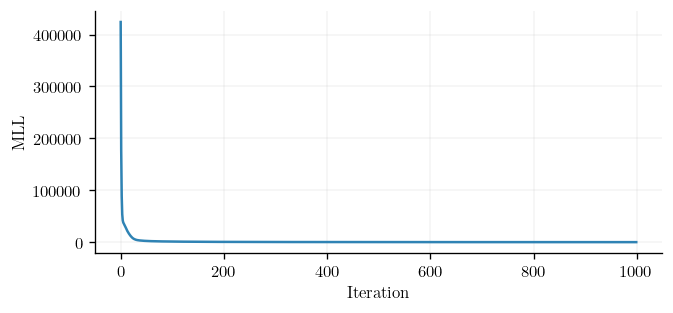

In [13]:
# Plot history of MLL
plt.plot(history)
plt.xlabel("Iteration")
plt.ylabel("MLL")
plt.show()

In [14]:
from gpjax.base import meta_leaves

leaves = meta_leaves(opt_posterior)
print(len(leaves))
leaves

8


[({'bijector': <tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
   'trainable': True,
   'pytree_node': True},
  Array([0.03798884], dtype=float64)),
 ({'name': ' kff_lengthscale',
   'bijector': <tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
   'trainable': False,
   'pytree_node': True},
  Array(2.5, dtype=float64)),
 ({'name': ' kxf_lengthscale',
   'bijector': <tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
   'trainable': False,
   'pytree_node': True},
  Array(2.5, dtype=float64)),
 ({'name': ' kxf_degradations',
   'bijector': <tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
   'trainable': False,
   'pytree_node': True},
  Array([1., 1., 1., 1., 1.], dtype=float64)),
 ({'name': ' 

In [15]:
pass

In [16]:
latent_dist = opt_posterior.predict(testing_times, train_data=dataset_train)
predictive_dist = opt_posterior.likelihood(latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.variance()

/opt/anaconda3/envs/project_wp289/lib/python3.11/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


In [17]:
def plot_gp(x_test, predictive_dist):
    """
    Plot LF GP given test points and prediction

    Parameters
    ----------
    x_test: array of shape (n, 3)
    predictive_dist:  jax mvn
    """

    predictive_mean = predictive_dist.mean()
    predictive_std = predictive_dist.variance()

    # (100,)
    x_test = x_test[:,0]

    import matplotlib as mpl
    cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]
    fig, ax = plt.subplots(figsize=(7.5, 2.5))

    ax.fill_between(
        x_test.squeeze(),
        predictive_mean - 2 * predictive_std,
        predictive_mean + 2 * predictive_std,
        alpha=0.2,
        label="Two sigma",
        color=cols[1],
    )
    ax.plot(
        x_test,
        predictive_mean - 2 * predictive_std,
        linestyle="--",
        linewidth=1,
        color=cols[1],
    )
    ax.plot(
        x_test,
        predictive_mean + 2 * predictive_std,
        linestyle="--",
        linewidth=1,
        color=cols[1],
    )
    
    ax.plot(x_test, predictive_mean, label="Predictive mean", color=cols[1])
    ax.legend(loc="center left", bbox_to_anchor=(0.975, 0.5))
    ax.set_xlabel("Time")
    ax.set_ylabel("mRNA Expression")

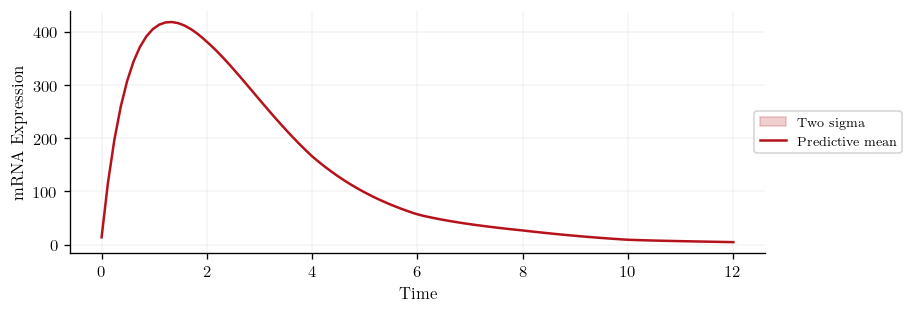

In [18]:
plot_gp(testing_times, predictive_dist)

In [19]:
for leaf in leaves:
    print(leaf[0], type(leaf[0]))

{'bijector': <tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>, 'trainable': True, 'pytree_node': True} <class 'dict'>
{'name': ' kff_lengthscale', 'bijector': <tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>, 'trainable': False, 'pytree_node': True} <class 'dict'>
{'name': ' kxf_lengthscale', 'bijector': <tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>, 'trainable': False, 'pytree_node': True} <class 'dict'>
{'name': ' kxf_degradations', 'bijector': <tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>, 'trainable': False, 'pytree_node': True} <class 'dict'>
{'name': ' kxf_sensitivities', 'bijector': <tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0

In [42]:
def get_params(opt_posterior):
    leaves = meta_leaves(opt_posterior)
    params = {}
    for leaf in leaves:
        name = leaf[0].get('name', '').strip()
        if name == 'kxx_sensitivities':
            params['learned_s'] = leaf[1]
        elif name == 'kxx_degradations':
            params['learned_d'] = leaf[1]
        elif name == 'kxx_lengthscale':
            params['learned_l'] = leaf[1]
    
    return params

In [43]:
get_params(opt_posterior)

{'learned_l': Array(0.72308435, dtype=float64),
 'learned_d': Array([0.2011247 , 1.25441558, 0.2815935 , 0.76138895, 0.2508647 ],      dtype=float64),
 'learned_s': Array([1.27655192, 1.52340735, 0.91220434, 0.79491096, 1.2233152 ],      dtype=float64)}

In [ ]:
def transfer_params(opt_posterior):
    # Use get params to get the learned parameters from kxx subkernel
    # Transfer these to kff and kxf subkernels
    pass

In [44]:
opt_posterior

ConjugatePosterior(prior=Prior(kernel=p53_combined_kernel(compute_engine=DenseKernelComputation(), active_dims=None, name='p53 Cov', kernel_xx=p53_kxx(compute_engine=DenseKernelComputation(), active_dims=[0], name='k_xx', true_s=Array([1.27655192, 1.52340735, 0.91220434, 0.79491096, 1.2233152 ],      dtype=float64), true_d=Array([0.2011247 , 1.25441558, 0.2815935 , 0.76138895, 0.2508647 ],      dtype=float64), l=Array(0.72308435, dtype=float64)), kernel_xf=p53_kxf(compute_engine=DenseKernelComputation(), active_dims=[0], name='k_xf', true_s=Array([1., 1., 1., 1., 1.], dtype=float64), true_d=Array([1., 1., 1., 1., 1.], dtype=float64), l=Array(2.5, dtype=float64)), kernel_ff=p53_kff(compute_engine=DenseKernelComputation(), active_dims=[0], name='RBF', l=Array(2.5, dtype=float64), variance=Array(1., dtype=float64, weak_type=True))), mean_function=Zero(constant=Array([0.], dtype=float32)), jitter=1e-06), likelihood=Gaussian(num_datapoints=35, integrator=AnalyticalGaussianIntegrator(), obs_

In [48]:
jax.tree_util.tree_structure(opt_posterior)

PyTreeDef(CustomNode(ConjugatePosterior[(['likelihood', 'prior'], [('jitter', 1e-06)])], [CustomNode(Gaussian[(['obs_stddev'], [('integrator', AnalyticalGaussianIntegrator()), ('num_datapoints', 35)])], [*]), CustomNode(Prior[(['kernel', 'mean_function'], [('jitter', 1e-06)])], [CustomNode(p53_combined_kernel[(['kernel_ff', 'kernel_xf', 'kernel_xx'], [('active_dims', None), ('compute_engine', DenseKernelComputation()), ('name', 'p53 Cov')])], [CustomNode(p53_kff[(['l'], [('active_dims', [0]), ('compute_engine', DenseKernelComputation()), ('name', 'RBF'), ('variance', Array(1., dtype=float64, weak_type=True))])], [*]), CustomNode(p53_kxf[(['l', 'true_d', 'true_s'], [('active_dims', [0]), ('compute_engine', DenseKernelComputation()), ('name', 'k_xf')])], [*, *, *]), CustomNode(p53_kxx[(['l', 'true_d', 'true_s'], [('active_dims', [0]), ('compute_engine', DenseKernelComputation()), ('name', 'k_xx')])], [*, *, *])]), CustomNode(Zero[([], [('constant', Array([0.], dtype=float32))])], [])])])

In [62]:
# Index based off dictionary
flattened_params = jax.tree_util.tree_flatten(opt_posterior)[0]
assert len(flattened_params) == len(leaves)
for i, (leaf, param) in enumerate(zip(leaves, flattened_params)):
    assert leaf[0] == param

TypeError: unsupported operand type(s) for ==: 'ArrayImpl' and 'dict'

In [61]:
opt_posterior_params = jax.tree_util.tree_flatten(opt_posterior)[0]
opt_posterior_params

[Array([0.03798884], dtype=float64),
 Array(2.5, dtype=float64),
 Array(2.5, dtype=float64),
 Array([1., 1., 1., 1., 1.], dtype=float64),
 Array([1., 1., 1., 1., 1.], dtype=float64),
 Array(0.72308435, dtype=float64),
 Array([0.2011247 , 1.25441558, 0.2815935 , 0.76138895, 0.2508647 ],      dtype=float64),
 Array([1.27655192, 1.52340735, 0.91220434, 0.79491096, 1.2233152 ],      dtype=float64)]

In [57]:
jax.flatten_util.ravel_pytree(opt_posterior)[0]

Array([0.03798884, 2.5       , 2.5       , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.72308435, 0.2011247 ,
       1.25441558, 0.2815935 , 0.76138895, 0.2508647 , 1.27655192,
       1.52340735, 0.91220434, 0.79491096, 1.2233152 ], dtype=float64)